In [1]:
#default_exp lesson2

In [2]:
import git
import os

In [3]:
repo = git.Repo(search_parent_directories=True)
repo_root = repo.git.rev_parse("--show-toplevel")
os.chdir(repo_root)
os.getcwd()

'/home/paperspace/development/fastai-part2'

In [178]:
#export
from solutions.lesson1 import *
from fastai.datasets import *
import torch
from torch import nn
import numpy as np
from functools import wraps
from typing import List, Tuple, Callable
from functools import partial
import math

In [5]:
import pdb

In [6]:
??get_data

Signature: get_data(data_path)
Docstring: <no docstring>
Source:   
def get_data(data_path):
  with gzip.open(data_path, mode="rb") as d:
    ((X_train, y_train), (X_valid, y_valid), _) = pickle.load(d, encoding='latin-1')
    X_train, y_train, X_valid, y_valid = map(torch.tensor, (X_train, y_train, X_valid, y_valid))
    return (X_train, y_train, X_valid, y_valid)
File:      ~/development/fastai-part2/solutions/lesson1.py
Type:      function


In [7]:
#export
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'
path = download_data(MNIST_URL, ext=".gz")
X_train, y_train, X_valid, y_valid = get_data(path)

In [8]:
X_train.shape, X_valid.shape

(torch.Size([50000, 784]), torch.Size([10000, 784]))

In [9]:
y_train.shape, y_valid.shape

(torch.Size([50000]), torch.Size([10000]))

# Model Class

In [10]:
class Model(nn.Module):
    def __init__(self, layers):
        self._modules = {}
        for idx, layer in enumerate(layers):
            self._modules[f'layer{idx}'] = layer
        
    def __call__(self, x):
        for _, layer in self.named_children(): x = layer(x)
        return x

In [11]:
nh = 50
ni = X_train.shape[1]
c = int(y_train.max()) + 1

In [12]:
model = Model([
    nn.Linear(ni, nh),
    nn.ReLU(),
    nn.Linear(nh, c)
])

In [13]:
model

Model(
  (layer0): Linear(in_features=784, out_features=50, bias=True)
  (layer1): ReLU()
  (layer2): Linear(in_features=50, out_features=10, bias=True)
)

In [14]:
pred = model(X_train)

In [15]:
pred.shape, pred

(torch.Size([50000, 10]),
 tensor([[ 0.1649, -0.1323, -0.1332,  ...,  0.0178,  0.1816, -0.1312],
         [ 0.2021, -0.1218, -0.1044,  ...,  0.0237,  0.1407, -0.1884],
         [ 0.1784, -0.1351,  0.0800,  ..., -0.0435,  0.0637, -0.2104],
         ...,
         [ 0.2268, -0.1062, -0.0394,  ...,  0.0007,  0.0349, -0.1669],
         [ 0.2270, -0.1668, -0.0366,  ...,  0.0573,  0.1204, -0.1750],
         [ 0.2221, -0.1500, -0.0601,  ..., -0.0797,  0.0627, -0.1602]],
        grad_fn=<AddmmBackward>))

# Log Softmax

First the naive way:

In [16]:
def log_softmax(vec):
    return (vec.exp() / vec.exp().sum(-1)).log()

In [17]:
assert log_softmax(torch.tensor([[1.,2.,3.]])).exp().sum() == 1

Then the numerically friendly way:

In [18]:
def log_softmax(vec):
    return vec - vec.exp().sum(-1).log()

In [19]:
assert log_softmax(torch.tensor([[1.,2.,3.]])).exp().sum() == 1

In [20]:
def nll(output, target):
    return -output[range(len(output)), target].mean() 

In [21]:
fake_output = torch.tensor([
    [0.5, 0.5],
    [0.3, 0.7]
])

fake_target = torch.tensor([
    0,
    1
])

In [22]:
log_first = np.log(0.5); log_first

-0.6931471805599453

In [23]:
log_second = np.log(0.7); log_second

-0.35667494393873245

In [24]:
correct_nll = -(log_first + log_second)/2

In [25]:
nll(torch.log(fake_output), fake_target)

tensor(0.5249)

In [26]:
assert torch.allclose(nll(fake_output.log(), fake_target), torch.tensor(correct_nll).float())

# LogSumExp

LogSumExp is a way of making the sum of exponents more numerically stable.

In [27]:
def logsumexp(vec):
    max_elem = vec.max()
    return max_elem + (vec - max_elem).exp().sum(-1).log()

In [28]:
assert torch.tensor([1,2,3]).float().exp().sum().log() == logsumexp(torch.tensor([1,2,3]).float())

This is a way of making the log of a sum of exponentials more numerically stable. You can take advantage of the fact that dividing two exponentials results in subtracting their exponents. You can factor out the largest exponential, which subtracts its exponent from each of the other exponents. Then you can take advantage of the log rules that state that log(ab) = log(a) + log(b), which allows you to add the highest exponential to the log of the sum of the others. 

In [29]:
assert logsumexp(torch.tensor([1,2,3]).float()) == torch.logsumexp(torch.tensor([1,2,3]).float(), dim=(0,))

## log_softmax in terms of LogSumExp

In [30]:
def log_softmax(vec):
    return vec - vec.logsumexp(dim=(0,), keepdim=True)

In [31]:
log_softmax(torch.tensor([1,2,3]).float()) == torch.log_softmax(torch.tensor([1,2,3]).float(), dim=0)

tensor([ True,  True, False])

In [32]:
np.array([[1,2,3], [3,4,5], [5,6,7]])[:, [0,1,2]]

array([[1, 2, 3],
       [3, 4, 5],
       [5, 6, 7]])

In [33]:
grad_example = torch.tensor([
    [0,0,1],
    [1,0,0],
    [0,1,0],
])

In [34]:
grad_example.argmax(dim=1)

tensor([2, 0, 1])

In [35]:
grad_example[range(len(grad_example)), grad_example.argmax(dim=1)] = 2

In [36]:
grad_example

tensor([[0, 0, 2],
        [2, 0, 0],
        [0, 2, 0]])

In [37]:
grad_example.nonzero()

tensor([[0, 2],
        [1, 0],
        [2, 1]])

In [38]:
grad_example[grad_example.nonzero()]

tensor([[[0, 0, 2],
         [0, 2, 0]],

        [[2, 0, 0],
         [0, 0, 2]],

        [[0, 2, 0],
         [2, 0, 0]]])

In [39]:
t = torch.tensor([
    [0,0,0,1,2],
    [3,5,3,0,0]
])

In [40]:
nonzero = t.nonzero()
xs = nonzero[:,0]
ys = nonzero[:,1]
t[xs, ys]

tensor([1, 2, 3, 5, 3])

In [41]:
tz = torch.zeros_like(t)
tz[xs, ys] = 1

In [42]:
tz

tensor([[0, 0, 0, 1, 1],
        [1, 1, 1, 0, 0]])

In [43]:
class LogSoftmax(nn.Module):
    def forward(self, x):
        self.input = x
        self.output = torch.log_softmax(self.input, dim=-1)
        return self.output
    
    def backward(self): 
        correct_labels = (self.output.grad > 0).float()
        msg = "LogSoftmax must be used with CE loss, found more than one output dim with nonzero gradients for the same example"
        assert correct_labels.sum(axis=0).max() == 1, msg
        self.input.grad = (correct_labels - self.output) * self.output.grad

In [44]:
mdl = Model([
    nn.Linear(784,100),
    nn.ReLU(),
    nn.Linear(100, c),
    LogSoftmax()
])
X_train.shape, mdl(X_train).shape

(torch.Size([50000, 784]), torch.Size([50000, 10]))

In [45]:
mdl2 = Model([
    nn.Linear(784,100),
    nn.ReLU(),
    nn.Linear(100, c),
    nn.LogSoftmax()
])

In [46]:
torch.exp(mdl(X_train))

tensor([[0.1192, 0.0925, 0.1062,  ..., 0.0985, 0.0800, 0.1085],
        [0.1168, 0.0898, 0.1032,  ..., 0.0934, 0.0867, 0.1223],
        [0.1158, 0.0884, 0.1044,  ..., 0.0942, 0.0923, 0.1078],
        ...,
        [0.1084, 0.0973, 0.1081,  ..., 0.0914, 0.0908, 0.1039],
        [0.1211, 0.1035, 0.0968,  ..., 0.0861, 0.0931, 0.1101],
        [0.1126, 0.0941, 0.0981,  ..., 0.0851, 0.0912, 0.1071]],
       grad_fn=<ExpBackward>)

In [47]:
loss = nn.NLLLoss()

In [48]:
l = loss(mdl(X_train), y_train)

In [49]:
l.backward()

In [50]:
a = torch.tensor([[1,2,3]]).float()
l = LogSoftmax()
l.forward(a)
l.output.grad = torch.tensor([[0,0,10]]).float()
l.backward()

In [51]:
torch.log_softmax(a, 1)

tensor([[-2.4076, -1.4076, -0.4076]])

In [52]:
print(a.grad)

tensor([[ 0.0000,  0.0000, 14.0761]])


In [53]:
assert torch.allclose(log_softmax(torch.tensor([1,2,3]).float()), torch.log_softmax(torch.tensor([1,2,3]).float(), dim=0))

In [54]:
print(list(mdl2.named_children()))

[('layer0', Linear(in_features=784, out_features=100, bias=True)), ('layer1', ReLU()), ('layer2', Linear(in_features=100, out_features=10, bias=True)), ('layer3', LogSoftmax())]


In [55]:
def fit(model, bs=64, lr=1e-3, epochs=1):
    n_batches = X_train.shape[0] // bs + 1
    losses = []
    for epoch in range(epochs):
        for i in range(n_batches):
            start_idx = i * bs
            end_idx = (i + 1) * bs
            X_b, y_b = X_train[start_idx:end_idx], y_train[start_idx:end_idx] 
            pred = model(X_b)
            loss = nll(pred, y_b)
            losses.append(loss.item())

            loss.backward()

            with torch.no_grad():
                for _, layer in model.named_children():
                    if hasattr(layer, 'weight'):
                        layer.weight.sub_(layer.weight.grad * lr)
                        layer.bias.sub_(layer.bias.grad * lr)
                        layer.zero_grad()
    print(losses[-1])

In [56]:
mdl

Model(
  (layer0): Linear(in_features=784, out_features=100, bias=True)
  (layer1): ReLU()
  (layer2): Linear(in_features=100, out_features=10, bias=True)
  (layer3): LogSoftmax()
)

In [57]:
for i,l in mdl.named_children(): 
    if hasattr(l, 'weight'): 
        print('has it')

has it
has it


In [59]:
# fit(mdl2, 64, epochs=10)

In [60]:
# fit(mdl, 64, epochs=100)

In [61]:
def nograd(f):
    @wraps(f)
    def inner(*args, **kwargs):
        with torch.no_grad():
            return f(*args, **kwargs)
    return inner

In [62]:
class Optimizer:
    def __init__(self, model, lr):
        self.hp = {
            "lr": lr
        }
        params = []
        for _, layer in model.named_children():
            if hasattr(layer, 'weight'):
                params.append(layer)
        self.params = params
    
    @nograd
    def step(self):
        for param in self.params:
            param.weight.sub_(param.weight.grad * self.hp['lr'])
            param.bias.sub_(param.bias.grad * self.hp['lr'])
                
    @nograd
    def zero_grad(self):
        for param in self.params:
            param.zero_grad() 

In [63]:
def fit(model, optimizer, bs=64, epochs=1):
    n_batches = X_train.shape[0] // bs
    losses = []
    for epoch in range(epochs):
        for i in range(n_batches):
            start_idx = i * bs
            end_idx = (i + 1) * bs
            X_b, y_b = X_train[start_idx:end_idx], y_train[start_idx:end_idx] 
            pred = model(X_b)
            loss = nll(pred, y_b)
            losses.append(loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    print(losses[-1])

In [64]:
# export
def basic_model(nh, torch_softmax=False):
    return nn.Sequential(
        nn.Linear(784, nh),
        nn.ReLU(),
        nn.Linear(nh, 10),
        nn.LogSoftmax() if torch_softmax else LogSoftmax()
    )

In [65]:
mdl = basic_model(100)
opt = Optimizer(mdl, 1e-3)
#fit(mdl, opt, epochs=10)

In [66]:
mdl2 = basic_model(100, True)
opt2 = Optimizer(mdl2, 1e-3)
#fit(mdl2, opt2, epochs=10)

In [67]:
# export
class Dataset:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.x.shape[0]

In [68]:
d = Dataset(X_train, y_train)

In [69]:
d[2:5]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([4, 1, 9]))

In [70]:
g = [(1,2), (3,4), (5,6)]

In [71]:
list(zip(*g))

[(1, 3, 5), (2, 4, 6)]

In [72]:
# export
class SequentialSampler:
    def __init__(self, ds):
        self.ds = ds
        
    def __iter__(self):
        for i in range(len(self.ds)):
            yield(i)
            
    def __len__(self):
        return len(self.ds)

In [73]:
# export
class DataLoader:
    def __init__(self, ds, bs, sampler=None):
        self.ds = ds
        self.bs = bs
        
        if callable(sampler):
            self.sampler = sampler(ds)
        else:
            self.sampler = sampler or SequentialSampler(ds)
    
    def __iter__(self):
        it = iter(self.sampler)
        nbatches = math.ceil(len(self) / self.bs)
        for _ in range(nbatches):
            try:
                idxs = []
                for _ in range(self.bs):
                    idxs.append(next(it))
                yield self.ds[idxs]
            except StopIteration:
                yield self.ds[idxs] # flush the final partial batch
                
    def __len__(self):
        return len(self.ds)

In [74]:
dl = DataLoader(d, 64)

In [79]:
next(iter(dl))[0].shape

torch.Size([64, 784])

In [80]:
min([len(yb) for xb,yb in dl]), max([len(yb) for xb,yb in dl])

(16, 64)

In [81]:
def fit(model, optimizer, dl, epochs=1):
    losses = []
    for _ in range(epochs):
        for X_b, y_b in dl:
            pred = model(X_b)
            loss = nll(pred, y_b)
            losses.append(loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    print(losses[-1])

In [82]:
mod = basic_model(100)

In [83]:
opt = Optimizer(mod, 1e-3)

In [84]:
#fit(mod, opt, dl, 100)

# Callbacks

In [85]:
class Callback:
    _order = 0
    
    def on_train_start(self):
        pass
        
    def on_epoch_start(self): 
        pass
    
    def on_batch_start(self): 
        pass
    
    def on_forward_start(self): 
        pass
    
    def on_forward_end(self): 
        pass
    
    def on_backward_start(self): 
        pass
    
    def on_backward_end(self): 
        pass
        
    def on_batch_end(self):
        pass
        
    def on_epoch_end(self):
        pass
    
    def on_train_end(self):
        pass

In [86]:
# export
class Learn:
    def __init__(self, model, optimizer, data, loss):
        self.model = model
        self.optimizer = optimizer
        self.data = data
        self.loss = loss

In [87]:
# class CallbackHandler:
#     def __init__(self, learn, callbacks, callback_fns):
#         self.callbacks = [cb(learn) for cb in callback_fns] + callbacks 
        
#     def on_train_start(self):
#         for callback in self.callbacks: callback.on_train_start()
        
#     def on_epoch_start(self):
#         for callback in self.callbacks: callback.on_epoch_start()
        
#     def on_batch_start(self): 
#         for callback in self.callbacks: callback.on_batch_start()
            
#     def on_forward_start(self): 
#         for callback in self.callbacks: callback.on_forward_start()
            
#     def on_forward_end(self): 
#         for callback in self.callbacks: callback.on_forward_end()
            
#     def on_backward_start(self): 
#         for callback in self.callbacks: callback.on_backward_start()
            
#     def on_backward_end(self): 
#         for callback in self.callbacks: callback.on_backward_end()
        
#     def on_batch_end(self):
#         for callback in self.callbacks: callback.on_batch_end()
        
#     def on_epoch_end(self):
#         for callback in self.callbacks: callback.on_epoch_end()
        
#     def on_train_end(self):
#         for callback in self.callbacks: callback.on_train_end()

In [88]:
# class CallbackHandler(Callback):
#     def __init__(self, learn, callbacks, callback_fns):
#         self.callbacks = [cb(learn) for cb in callback_fns] + callbacks 
        
#     def __getattr__(self, attr):
#         if attr.startswith('on_'):
#             for callback in sorted(self.callbacks, key=lambda x: x._order): 
#                 f = getattr(callback, attr) 
#                 if f and f(): return False # false means don't stop

In [89]:
# export
class ModelMode:
    TRAIN = 0
    VALID = 1
    TEST = 2

In [90]:
# export
class DataBunch:
    def __init__(self, train_dl, valid_dl, test_dl=None, c=None):
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.test_dl = test_dl
        self.c = c

In [91]:
# export
class Runner(object): 
    def __init__(self, learn, cbs=None, cb_funcs=None):
        self.learn = learn
        cb_funcs = cb_funcs or []
        cbs = cbs or []
        self.cbs = cbs + [cb_func(self) for cb_func in cb_funcs]
        
        self.train_losses = []
        self.train_counts = []
        self.valid_losses = []
        self.valid_counts = []
        
        self.batches = 0
        
    def train(self):
        self.mode = ModelMode.TRAIN
        
    def valid(self):
        self.mode = ModelMode.VALID
        
    def mode(self):
        return self.mode 
        
    def one_batch(self, xb, yb):
        self.xb, self.yb = xb, yb
        pred = self.learn.model(xb)
        loss = self.learn.loss(pred, yb) 
         
        if self.mode == ModelMode.TRAIN:
            if self('on_batch_start'): return
            self.batches += 1
            self.train_losses.append(loss.item())
            self.train_counts.append(len(xb))
            loss.backward()
            if not self('on_step_start'): self.learn.optimizer.step()
            self.learn.optimizer.zero_grad()
            self('on_step_end') 
            if self('on_batch_end'): return True
            
        if self.mode == ModelMode.VALID:
            self.valid_losses.append(loss.item())     
            self.valid_counts.append(len(xb))
        
    def all_batches(self):
        if self('on_epoch_start'): return
        self.epochs += 1
        dl = self.learn.data.train_dl if self.mode == ModelMode.TRAIN else self.learn.data.valid_dl
        for xb, yb in dl:
            self.one_batch(xb, yb)
        self('on_epoch_end') 
        
    def fit(self, epochs=1):
        self.total_batches = math.ceil(len(learn.data.train_dl) / learn.data.train_dl.bs) * epochs
        self('on_train_start')
        self.epochs = 0
        for _ in range(epochs):
            self.train()     
            if self.all_batches(): return
            
            self.valid()
            if self.all_batches(): return
            print("Validation loss: {0:.4f}".format(self.loss(ModelMode.VALID)))
            self.epochs += 1
        self('on_train_end')
        
    def loss(self, mode: int):
        if mode == ModelMode.TRAIN:
            values, counts = self.train_losses, self.train_counts
        elif mode == ModelMode.VALID:
            values, counts = self.valid_losses, self.valid_counts
        else:
            raise ValueError("mode must be one of ModelMode.TRAIN or ModelMode.VALID.")
            
        total = sum(counts)
        weights = [i/total for i in counts]
        return sum([value*weight for value, weight in zip(values, weights)]) 
        
    def __call__(self, name):
        for cb in sorted(self.cbs, key=lambda x: x._order):
            f = getattr(cb, name, None)
            if f and f(): return True
        return False 

In [92]:
X_train, y_train

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4,  ..., 8, 4, 8]))

In [93]:
X_valid, y_valid

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([3, 8, 6,  ..., 5, 6, 8]))

In [94]:
train_ds = Dataset(X_train, y_train)
valid_ds = Dataset(X_valid, y_valid)

In [95]:
train_dl = DataLoader(train_ds, 64)
valid_dl = DataLoader(valid_ds, 128)

In [96]:
data = DataBunch(train_dl, valid_dl)

In [97]:
# slow
mdl = basic_model(100)
opt = Optimizer(mdl, 1e-3)
learn = Learn(mdl, opt, data, nn.NLLLoss())

In [98]:
basic_runner = Runner(learn)

In [99]:
# basic_runner.fit(10)

In [100]:
# basic_runner.loss(ModelMode.VALID)

# BasicCallback

In [101]:
class BasicCallback:
    _order = 0
    
    def __init__(self, runner: Runner):
        self.runner = runner
        
    def on_batch_end(self):
        print(self.runner.batches)
        if self.runner.batches == 10:
            print("Done!")
            return True

In [102]:
basic_runner_cb = Runner(learn, cb_funcs=[BasicCallback])

In [103]:
# basic_runner_cb.fit(10)

# Scheduler

In [104]:
class LinearScheduler:
    _order = 0
    def __init__(self, start: float, stop: float, hp: str, runner: Runner):
        self.start = start
        self.stop = stop
        self.runner = runner 
        self.hp = hp
        
    def on_batch_end(self):
        pos = self.runner.batches / self.runner.total_batches
        new_hp = start + (self.stop - self.start) * pos
        self.runner.learn.optimizer.hp[self.hp] = new_hp
        if pos % 0.1 == 0:
            print("The {} is now {}".format(self.hp, new_hp)) 

In [105]:
def lin_scheduler(start: float, stop: float, hp: str) -> partial: return partial(LinearScheduler, start, stop, hp)

In [106]:
lin_scheduler(10, 50, 'lr')

functools.partial(<class '__main__.LinearScheduler'>, 10, 50, 'lr')

In [264]:
class Scheduler:
    pass

class CosineScheduler(Scheduler):
    _order = 0
    def __init__(self, start: float, stop: float, hp: str, runner: Runner):
        self.start = start
        self.stop = stop
        self.runner = runner 
        self.hp = hp
        
    def on_batch_end(self, pos: float = None):
        pos = pos or self.runner.batches / self.runner.total_batches
        new_hp = self.start + (1 + math.cos(math.pi*(1-pos))) * (self.stop - self.start) / 2
        self.runner.learn.optimizer.hp[self.hp] = new_hp
        if pos % 0.1 == 0 or pos == 0 or pos == 1:
            print("The {} is now {} for pos {} (batch {})".format(self.hp, new_hp, pos, self.runner.batches)) 

In [265]:
math.ceil(len(data.train_dl) / data.train_dl.bs)

782

In [266]:
def cos_scheduler(start: float, stop: float, hp: str) -> partial: return partial(CosineScheduler, start, stop, hp)

In [267]:
runner_cbs = Runner(learn, cb_funcs=[cos_scheduler(1e-5, 1e-1, 'lr')])

In [308]:
# runner_cbs.fit(10)

# Combining Schedulers

We need to:
1. Check to see what percentage of batches have been processed
2. Depending on what percentage we're up to, determine which scheduler to use
3. For that scheduler, calculate the HP value based on what point in the phase we're at

Each one treats percentages independently; so if the first phase needs to go from 0.3 to 0.8 over the first 70% of batches, and there are 100 batches total, then batch 70 needs to look like the "100%" mark for the first scheduler. What we can do is:
* take these percentages and construct intervals, which are tuples of batch indices (e.g. (0,70) for the example above). 
* Select the interval for the batch that we're currently in
* Subtract batch num - interval_beginning / (interval_end - interval_beginning) to get the percentage
* Pass that percentage to the scheduler associated with that interval

In [269]:
class CombinedScheduler(Scheduler):
    _order = 0
    def __init__(self, percentages: List[float], *scheduler_fns: Callable[[Runner], Scheduler]):
        assert sum(percentages) == 1.
        self.percentages = percentages
        self.intervals = [(percentages[i-1], percentages[i]) for i in range(0,len(percentages))]
        self.phases = self._build_phases(percentages)
        self.scheduler_fns = scheduler_fns
        self.schedulers = None
        
    def on_batch_end(self):
        if self.schedulers is None:
            print("Must build the schedulers by calling build_schedulers(runner) before calling on_batch_end.")
        runner = self.schedulers[0].runner
        # all schedulers must refer to the same runner
        assert all([i.runner == runner for i in self.schedulers])
        pos = runner.batches / runner.total_batches
        phase_idx = self._get_phase(pos)
        phase = self.phases[phase_idx]
        scheduler = self.schedulers[phase_idx]
        phase_pct = pos - phase[0]
        phase_size = phase[1] - phase[0]
        effective_pct = phase_pct / phase_size 
        scheduler.on_batch_end(effective_pct)
        
    def _build_phases(self, pcts: List[float]) -> List[Tuple[float, float]]:
        pcts = [0] + pcts
        cumsum = torch.cumsum(torch.tensor(pcts), dim=-1).tolist()
        intervals = [(round(cumsum[i-1], 1), round(cumsum[i], 1)) for i in range(1, len(cumsum))]
        return intervals
    
    def _get_phase(self, pos: float) -> int:
        for idx, phase in enumerate(self.phases):
            if phase[0] < pos <= phase[1]:
                return idx 
            
    def build_schedulers(self, runner: Runner):
        self.schedulers = [i(runner) for i in self.scheduler_fns]
         
    def __call__(self, runner: Runner):
        self.build_schedulers(runner)
        return self

In [270]:
percentages = [0.7, 0.3]

In [271]:
[(percentages[i-1], percentages[i]) for i in range(0,len(percentages))]

[(0.3, 0.7), (0.7, 0.3)]

In [272]:
torch.cumsum(torch.tensor(percentages), dim=-1)

tensor([0.7000, 1.0000])

In [273]:
def build_phases(pcts: List[float]) -> List[Tuple[float, float]]:
    pcts = [0] + pcts
    cumsum = torch.cumsum(torch.tensor(pcts), dim=-1).tolist()
    intervals = [(round(cumsum[i-1], 1), round(cumsum[i], 1)) for i in range(1, len(cumsum))]
    return intervals

In [274]:
build_phases([0.7, 0.3])

[(0.0, 0.7), (0.7, 1.0)]

In [275]:
assert build_phases([0.7, 0.3]) == [(0, 0.7), (0.7, 1.0)]

In [276]:
def get_phase(pos: float, phases: List[Tuple[float, float]]) -> int:
    for idx, phase in enumerate(phases):
        if phase[0] < pos <= phase[1]:
            return idx 

In [277]:
assert get_phase(0.5, [(0, 0.7), (0.7, 1.0)]) == 0

In [278]:
assert get_phase(0.8, [(0, 0.7), (0.7, 1.0)]) == 1

In [297]:
class Recorder:
    _order=1
    
    def __init__(self, runner: Runner):
        self.runner = runner
        self.values = []
    
    def on_batch_end(self):
        self.values.append(self.runner.learn.optimizer.hp.copy()) 

In [298]:
model = basic_model(10)
opt = Optimizer(model, 1e-3)
learn = Learn(model, opt, data, nn.NLLLoss())
scheduler = CombinedScheduler([0.3, 0.7], cos_scheduler(1e-5, 1e-1, 'lr'), cos_scheduler(1e-1, 1e-3, 'lr'))
run = Runner(learn, cb_funcs=[scheduler, Recorder])

In [299]:
run.fit(10)

Validation loss: 0.9420
Validation loss: 0.6580
The lr is now 0.1 for pos 1.0 (batch 2346)
Validation loss: 0.5418
Validation loss: 0.4766
Validation loss: 0.4344
Validation loss: 0.4046
Validation loss: 0.3818
Validation loss: 0.3633
Validation loss: 0.3484
The lr is now 0.0010000000000000009 for pos 1.0 (batch 7820)
Validation loss: 0.3365


In [301]:
lrs = [i['lr'] for i in run.cbs[1].values]

In [305]:
import pandas as pd

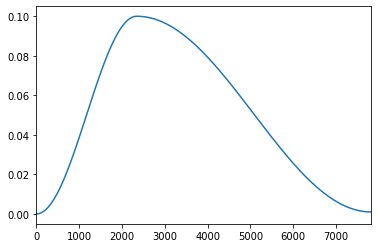

In [307]:
pd.Series(lrs).plot()